### 毒蘑菇图像识别实验

#### 1.环境准备

In [1]:
!unzip Mushrooms.zip

Archive:  Mushrooms.zip
   creating: Mushrooms/Exidia/
  inflating: Mushrooms/Exidia/AA2017-9187387_SJnQ_ug5g.jpg  
  inflating: Mushrooms/Exidia/ALP2011PIC54982557.jpg  
  inflating: Mushrooms/Exidia/ALP2011PIC59018597.jpg  
  inflating: Mushrooms/Exidia/ALP2011PIC73457029.jpg  
  inflating: Mushrooms/Exidia/ALP2012PIC20537390.jpg  
  inflating: Mushrooms/Exidia/ANJE2015-9190621_ryH7PRP0x.jpg  
  inflating: Mushrooms/Exidia/AOJ2016-9181647_BJenv5fYee.jpg  
  inflating: Mushrooms/Exidia/AOJ2016-9181647_Bknv9ztgx.jpg  
  inflating: Mushrooms/Exidia/APE2016-9181471_S1Hlq3Pxg.jpg  
  inflating: Mushrooms/Exidia/APE2016-9181471_SyeHlcnvxg.jpg  
  inflating: Mushrooms/Exidia/APE2016-9182993_HJloGs-Gze.jpg  
  inflating: Mushrooms/Exidia/APE2016-9182993_rywR4AHze.jpg  
  inflating: Mushrooms/Exidia/APE2016-9182993_S1biMobGGe.jpg  
  inflating: Mushrooms/Exidia/APE2016-9182993_S1sMo-MMe.jpg  
  inflating: Mushrooms/Exidia/APE2016-9184941_rkoAsQWSx.jpg  
  inflating: Mushrooms/Exidia/APE2016-9

In [3]:
# 数据文件准备
!pip install split-folders
import splitfolders
splitfolders.ratio("Mushrooms", output="data", seed=1706, ratio=(.8, .0, .2)) # 这里Mushrooms是原始数据文件夹，data是切分后的数据文件夹

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple


Copying files: 1053 files [00:00, 2156.66 files/s]


In [4]:
# python环境准备
import mindspore.dataset as ds # 数据集载入
import mindspore.nn as nn # 各类网络层都在nn里面
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor # 回调函数
from mindspore.train import Model # 承载网络结构
from mindspore import load_checkpoint # 读取最佳参数
from mindspore import context # 设置mindspore运行的环境

from easydict import EasyDict as ed # 超参数保存
import numpy as np # numpy
import matplotlib.pyplot as plt # 可视化

# 文件处理相关
import os

# 华为云文件传输相关
# import moxing

In [5]:
# mindspore环境设置
device_target = context.get_context('device_target') # 获取运行装置（CPU，GPU，Ascend）
dataset_sink_mode = True if device_target in ['Ascend','GPU'] else False # 是否将数据通过pipeline下发到装置上
context.set_context(mode = context.GRAPH_MODE, device_target = device_target) # 设置运行环境，静态图context.GRAPH_MODE指向静态图模型，即在运行之前会把全部图建立编译完毕

print(f'device_target: {device_target}')
print(f'dataset_sink_mode: {dataset_sink_mode}') 

device_target: Ascend
dataset_sink_mode: True


#### 2.参数设置

In [6]:
# 数据路径
train_path = os.path.join("data", 'train')
test_path = os.path.join("data", 'test')

# 超参数
config = ed({
    # 训练参数
    'batch_size': 32,
    'epochs': 150,
    
    #网络参数
    'class_num': 9,

    # 动态学习率调节
    'warmup_epochs': 5,
    'lr_init': 0.01,
    'lr_max': 0.1,

    # 优化器参数
    'momentum': 0.9,
    'weight_decay': 4e-5}) 


#### 3.数据处理与展示

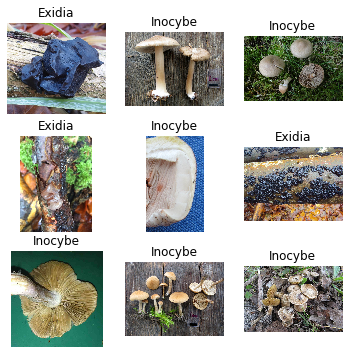

In [7]:
# 创建图像标签列表
category_dict = {0:'Exidia',1:'Inocybe'}

# 载入展示用数据
demo_ds = ds.ImageFolderDataset(test_path, decode=True)

# 设置图像大小
plt.figure(figsize=(6, 6))

# 打印9张子图
i = 1
for dic in demo_ds.create_dict_iterator():
    plt.subplot(3,3,i)
    plt.imshow(dic['image'].asnumpy()) # asnumpy：将 MindSpore tensor 转换成 numpy
    plt.axis('off')
    plt.title(category_dict[dic['label'].asnumpy().item()])
    i +=1
    if i > 9 :
        break

plt.show() 


In [9]:
train_ds = ds.ImageFolderDataset(train_path, decode=True)
#计算数据集平均数和标准差，数据标准化时使用
tmp = np.asarray( [np.mean(x['image'], axis=(0, 1)) for x in train_ds.create_dict_iterator(output_numpy=True)] )
RGB_mean = tuple(np.mean(tmp, axis=(0)))
RGB_std = tuple(np.std(tmp, axis=(0)))

print(RGB_mean)
print(RGB_std) 


(118.02704127202831, 109.78789744958608, 95.084993544675)
(33.96863946344604, 28.219597030209787, 32.25010584024198)


#### 4.网络定义

In [19]:
from preprocess import create_dataset

In [20]:
# 这里将网络分为backbone和head，backbone是ResNet包含残差块的部分，head是最后的全连接层。
from network import resnet50_backbone, resnet50_head

# 最终网络由backbone和head组成。
class ResNet50(nn.Cell):
    """
    ResNet architecture.

    Args:
        backbone (Cell): ResNet50 backbone网络
        head (Cell): ResNet50 head网络
    Returns:
        Tensor, 输出张量

    Examples:
        >>> ResNet50(resnet_backbone,
        >>>          resnet_head)
    """

    def __init__(self, backbone, head):
        super(ResNet50, self).__init__()

        self.backbone = backbone
        self.head = head

    def construct(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x 


In [21]:
# 训练集
train_data = create_dataset(data_path=train_path, 
                            mean=RGB_mean, 
                            std=RGB_std, 
                            batch_size=config.batch_size, 
                            usage='train',
                            repeat_num=1)

# 测试集
test_data = create_dataset(data_path=test_path, 
                            mean=RGB_mean, 
                            std=RGB_std, 
                            batch_size=config.batch_size, 
                            usage='test',
                            repeat_num=1) 

In [22]:
from lr_scheduler import get_lr

# 训练step总数
train_step_size = train_data.get_dataset_size()

# 学习率数组
lr = get_lr(total_epochs=config.epochs, 
            steps_per_epoch=train_step_size,
            lr_init=config.lr_init,
            lr_max=config.lr_max,
            warmup_epochs=config.warmup_epochs) 


#### 6.模型训练

In [23]:
#构建网络
# 网络
backbone_net = resnet50_backbone() 
load_checkpoint("best_param_backbone.ckpt",backbone_net)# 使用之前保存好的best_param_backbone.ckpt作为backbone网络
head_net = resnet50_head(config.class_num) # head网络，resnet50最后的全连接层
net = ResNet50(backbone_net, head_net)
# 损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 优化器
opt = nn.Momentum(net.trainable_params(), lr, momentum=config.momentum, weight_decay=config.weight_decay)

# 模型
model = Model(net, loss_fn = net_loss,
              optimizer = opt, metrics = {'accuracy','loss'})

[WARNING] ME(12625:281473288263552,MainProcess):2023-05-22-21:52:43.814.842 [mindspore/train/serialization.py:674] For 'load_param_into_net', remove parameter backbone.conv1.weight's prefix name: backbone., continue to load it to net parameter conv1.weight.


In [24]:
from callbacks import TrainHistroy,EvalHistory
time_cb = TimeMonitor(data_size=train_step_size) # 监控每次迭代的时间
loss_cb = LossMonitor() # 监控loss值
hist = {'loss':[], 'loss_eval':[], 'acc_eval':[]} # 训练过程记录

# 记录每次迭代的模型准确率
train_hist_cb = TrainHistroy(hist['loss'])

# 测试并记录模型在验证集的loss和accuracy，并保存最优网络参数
eval_hist_cb = EvalHistory(model = model,
                           backbone = backbone_net,
                           loss_history = hist['loss_eval'], 
                           acc_history = hist['acc_eval'], 
                           eval_data = test_data)

cb = [time_cb, loss_cb, train_hist_cb, eval_hist_cb] 

In [25]:
model.train(config.epochs, train_data, callbacks=cb) 

epoch: 1 step: 26, loss is 0.42115145921707153
epoch time: 86307.392 ms, per step time: 3319.515 ms
acc_eval:  0.8968253968253969
epoch: 2 step: 26, loss is 0.5068175792694092
epoch time: 799.617 ms, per step time: 30.754 ms
acc_eval:  0.8095238095238095
epoch: 3 step: 26, loss is 0.1813821792602539
epoch time: 792.439 ms, per step time: 30.478 ms
acc_eval:  0.873015873015873
epoch: 4 step: 26, loss is 0.5936641693115234
epoch time: 792.522 ms, per step time: 30.482 ms
acc_eval:  0.8968253968253969
epoch: 5 step: 26, loss is 0.23936426639556885
epoch time: 809.080 ms, per step time: 31.118 ms
acc_eval:  0.8571428571428571
epoch: 6 step: 26, loss is 0.6857985854148865
epoch time: 794.775 ms, per step time: 30.568 ms
acc_eval:  0.9365079365079365
epoch: 7 step: 26, loss is 0.24128076434135437
epoch time: 794.305 ms, per step time: 30.550 ms
acc_eval:  0.9047619047619048
epoch: 8 step: 26, loss is 0.31041237711906433
epoch time: 797.459 ms, per step time: 30.672 ms
acc_eval:  0.8571428571

#### 7.模型评估

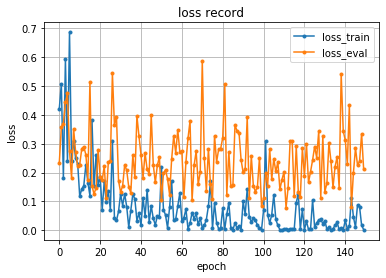

In [26]:
# 定义loss记录绘制函数
def plot_loss(hist):
    plt.plot(hist['loss'], marker='.')
    plt.plot(hist['loss_eval'], marker='.')
    plt.title('loss record')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss_train', 'loss_eval'], loc='upper right')
    plt.show()
    plt.close()

plot_loss(hist) 


In [ ]:
def plot_accuracy(hist):
    plt.plot(hist['acc_eval'], marker='.')
    plt.title('accuracy history')
    plt.xlabel('epoch')
    plt.ylabel('acc_eval')
    plt.grid()
    plt.show()
    plt.close()

plot_accuracy(hist) 


In [27]:
# 使用准确率最高的参数组合建立模型，并测试其在验证集上的效果
load_checkpoint('best_param.ckpt', net=net)
res = model.eval(test_data, dataset_sink_mode=False)
print(res) 


{'loss': 0.11318391934037209, 'accuracy': 0.9523809523809523}


#### 8.·效果展示

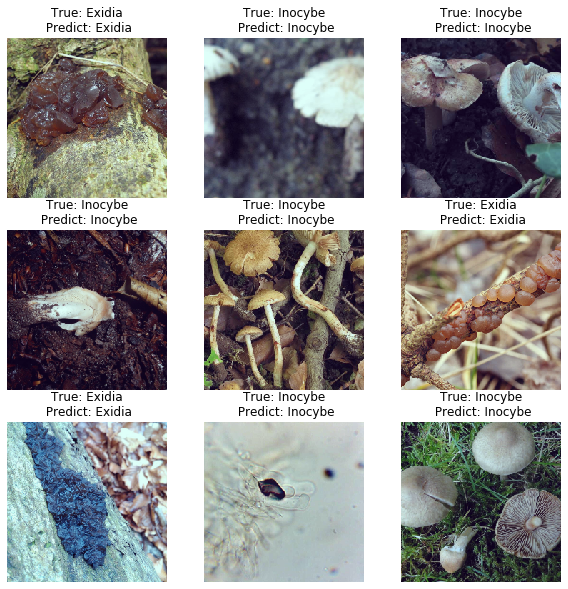

In [29]:
# 创建图像标签列表
category_dict = {0:'Exidia',1:'Inocybe'}

ds_test_demo = create_dataset(test_path, mean=RGB_mean, std=RGB_std, batch_size=1, usage='test')

# 将数据标准化至0~1区间
def normalize(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

# 设置图像大小
plt.figure(figsize=(10,10))
i = 1
# 打印9张子图
for dic in ds_test_demo.create_dict_iterator():
    # 预测单张图片
    input_img = dic['image']
    output = model.predict(input_img)
    predict = np.argmax(output.asnumpy(),axis=1)[0] # 反馈可能性最大的类别
    
    # 可视化
    plt.subplot(3,3,i)
    input_image = np.squeeze(input_img.asnumpy(),axis=0).transpose(1,2,0) # 删除batch维度
    input_image = normalize(input_image) # 重新标准化，方便可视化
    plt.imshow(input_image)
    plt.axis('off')
    plt.title('True: %s\n Predict: %s'%(category_dict[dic['label'].asnumpy().item()],category_dict[predict]))
    i +=1
    if i > 9 :
        break

plt.show() 


#### 9.模型保存